# Basic object detection - Introduction
This is the third part of my [dezeenAI](https://github.com/adamsiemaszkiewicz/dezeenAI) project meant to build an object and colour detection search engine based on the [Dezeen.com](http://dezeen.com/)'s Interior category.

This notebook used YOLOv4 object detection system with the out-of-the-box classes and weights to tag the image dataset.

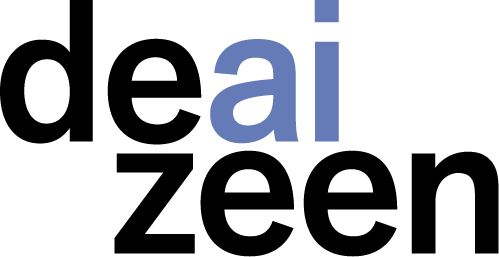

# Environment setup

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [1]:
# mount Google Drive on the runtime
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# create a symbolic link to a working directory
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/dezeenAI /mydrive

# navigate to the working directory
%cd /mydrive

/content/gdrive/My Drive/Colab Notebooks/dezeenAI


## Libraries & functions
- `cv2` - computer vision library
- `matplotlib.pyplot` - visualisation & plotting library
- `sys` - system-specific parameters and functions
- `os.path` - common pathname manipulations

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os.path
import pandas as pd
import numpy as np
import timeit
import tqdm.notebook as tq

#Darknet YOLOv4
YOLO (*You Only Look Once*) is an object detection system in real-time that recognizes various objects in a single enclosure. Currently it's one of the fastest and most precise object recognition systems.

Paper: [YOLOv4: Optimal Speed and Accuracy of Object Detection](https://arxiv.org/abs/2004.10934)

Code: [AlexeyAB/darknet](https://github.com/AlexeyAB/darknet)

Medium article: [YOLOv4 — the most accurate real-time neural network on MS COCO dataset.](https://medium.com/@alexeyab84/yolov4-the-most-accurate-real-time-neural-network-on-ms-coco-dataset-73adfd3602fe)

## Clone the repository
Let's first clone the official Darknet repository.

In [4]:
# !git clone https://github.com/AlexeyAB/darknet

## GPU, OpenCV & CUDA
In order for the processing to run faster it's better to enable GPU acceleration within Colab notebook which will make the runtime 100 times faster. In order for Darknet to work propely we need to enable OpenCV and CUDA as well. To do so:

1. Navigate to `Edit -> Notebook settings -> Hardware Accelerator: GPU`
2. Use `sed -i` bash command to write some lines in-place to the `Makefile` to enable OpenCV, GPU and CUDNN.

In [5]:
# %cd /mydrive/darknet
# !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
# !sed -i 's/GPU=0/GPU=1/' Makefile
# !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
# !sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

## Verify CUDA
CUDA is a parallel computing platform and application programming interface model created by Nvidia. It allows to use a CUDA-enabled graphics processing unit.

In [6]:
# !/usr/local/cuda/bin/nvcc --version

## Make Darknet
`make` command builds Darknet and creates executables to run or train object detectors

In [7]:
# !make

## Weights
YOLOv4 comes with pre-trained weights trained on 80 object categories of [MS COCO Dataset](https://cocodataset.org/) which is a good starting point for further development. Let's download them from the official Darknet repository using `wget`.

In [8]:
# !wget -nc https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

# Detection model

## Images DataFrame

In [9]:
df = pd.read_pickle('files/images_colours.pkl')
df = df[::-1]
df.reset_index(drop=True, inplace=True)
df

,id,url,path,dist1,dist2,dist3,dist4,dist5,dist6,dist7,dist8,dist9,dist10,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10
0,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...,0.039062,0.054688,0.175781,0.144531,0.242188,0.042969,0.070312,0.109375,0.113281,0.007812,"[233.2, 172.3, 84.0]","[60.5, 73.78571428571429, 91.57142857142857]","[141.0888888888889, 77.8, 17.93333333333333]","[92.27027027027027, 48.97297297297297, 11.8108...","[16.129032258064512, 62.35483870967742, 110.61...","[34.36363636363637, 36.81818181818182, 43.9090...","[193.44444444444446, 116.16666666666666, 31.33...","[47.035714285714285, 17.57142857142857, 3.7857...","[151.9655172413793, 101.27586206896552, 44.137...","[70.0, 116.5, 161.5]"
1,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...,0.042969,0.183594,0.125000,0.105469,0.031250,0.062500,0.117188,0.082031,0.128906,0.121094,"[36.272727272727266, 55.0, 84.18181818181819]","[121.38297872340425, 65.48936170212767, 17.255...","[197.25, 119.875, 45.09375]","[28.51851851851852, 13.81481481481481, 11.0]","[252.75, 209.75, 135.875]","[144.4375, 103.25, 68.5]","[34.03333333333333, 86.03333333333333, 171.8]","[166.23809523809524, 94.9047619047619, 23.9047...","[225.03030303030303, 156.8181818181818, 67.030...","[81.64516129032259, 40.54838709677419, 9.70967..."
2,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...,0.070312,0.042969,0.121094,0.183594,0.089844,0.039062,0.105469,0.125000,0.167969,0.054688,"[109.44444444444444, 76.5, 41.111111111111114]","[214.0909090909091, 133.1818181818182, 56.1818...","[14.967741935483872, 6.41935483870968, 2.25806...","[73.95744680851064, 33.40425531914894, 8.68085...","[169.7826086956522, 88.78260869565217, 25.6086...","[166.2, 118.5, 74.6]","[47.77777777777778, 18.851851851851855, 5.2222...","[127.46875, 61.21875, 14.4375]","[94.69767441860465, 46.0, 12.930232558139535]","[217.07142857142856, 162.42857142857144, 103.9..."
3,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...,0.132812,0.105469,0.156250,0.058594,0.093750,0.097656,0.003906,0.171875,0.085938,0.093750,"[23.441176470588232, 10.411764705882355, 6.764...","[177.66666666666666, 116.37037037037038, 62.70...","[113.8, 66.15, 27.075]","[217.73333333333335, 169.0, 119.0]","[91.125, 46.54166666666667, 15.375]","[157.6, 90.84, 34.84]","[255.0, 255.0, 243.0]","[60.27272727272727, 28.113636363636367, 12.477...","[211.13636363636363, 143.5, 70.27272727272728]","[124.83333333333333, 88.29166666666667, 59.375]"
4,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...,0.035156,0.105469,0.097656,0.062500,0.082031,0.125000,0.132812,0.167969,0.082031,0.109375,"[244.44444444444446, 199.55555555555554, 137.3...","[80.88888888888889, 41.37037037037037, 14.0370...","[129.72, 81.44, 46.2]","[217.625, 143.9375, 62.8125]","[91.42857142857143, 65.04761904761905, 43.0952...","[128.09375, 57.4375, 8.15625]","[44.705882352941174, 22.852941176470587, 11.67...","[14.79069767441861, 9.581395348837212, 8.18604...","[169.66666666666666, 113.76190476190476, 70.14...","[176.60714285714286, 96.5, 28.428571428571427]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44829,15,https://static.dezeen.com/uploads/2006/11/1dez...,/mydrive/data/dezeen/15/1dezeen_november-07.jpg,0.046875,0.109375,0.039062,0.164062,0.066406,0.062500,0.160156,0.093750,0.097656,0.160156,"[33.75, 24.66666666666667, 10.666666666666664]","[128.42857142857142, 106.64285714285714, 71.64...","[217.6, 200.7, 172.4]","[84.0952380952381, 65.30952380952381, 36.30952...","[160.64705882352942, 143.11764705882354, 110.3...","[190.75, 171.3125, 137.6875]","[112.85365853658537, 94.04878048780488, 63.682...","[63.166666666666664, 48.416666666666664, 25.04...","[145.0, 122.6

## Helper functions

In [10]:
def showIMG(path):
  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(
      image,
      (3*width, 3*height),
      interpolation = cv2.INTER_CUBIC
      )

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis('off')
  plt.imshow(
      cv2.cvtColor(
          resized_image,
          cv2.COLOR_BGR2RGB
          )
      )
  plt.show()

## Test
Darknet is now built and ready to run detections using YOLOv4 and pre-trained weights. It can already detect 80 classes of COCO Dataset. Let's test its performance on a pre-uploaded test picture.

- `./darknet detector test` - YOLOv4 detection function
- `coco.data` - dataset configuration
- `yolov4.cfg` - system architecture configuration
- `yolov4.weights` - pre-trained weights
- `-dont_show` - skips outputting the prediction picture (Notebook shows an error when trying to display the prediction) 
- `-tresh 0.5` - sets the treshold value for predictions

/content/gdrive/My Drive/Colab Notebooks/dezeenAI/darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
  

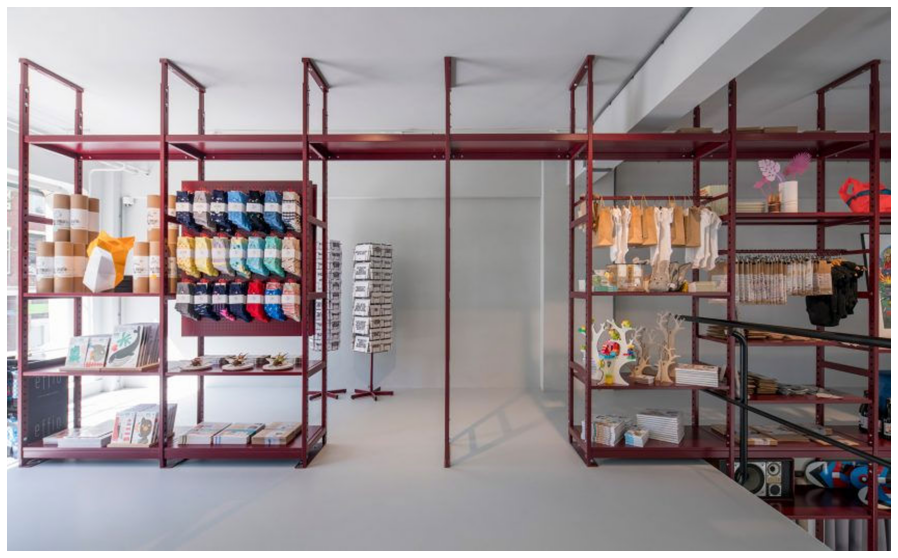

/content/gdrive/My Drive/Colab Notebooks/dezeenAI


In [11]:
# navigate to darknet directory
%cd darknet

# extract a random image path
path = df['path'][np.random.randint(0, df.shape[0])]

# make sure the permissions are ok
!chmod +x ./darknet

# run a YOLOv4 detector
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights -dont_show -thresh 0.5 {path}

# show the image with object detection predictions
showIMG('predictions.jpg')

# navigate back to the working directory
%cd /mydrive

## Split dataset
1. Let's divide our dataset into smaller chunks to be able to do the predictions on smaller batches.
2. Save the list of split files into a list to iterate through

In [12]:
%cd /mydrive/files
%mkdir -p tmp

paths = df['path']

chunksize = 2000

for n in range(int(len(paths)/chunksize)+1):

  start = n*chunksize
  end = ((n+1)*chunksize)-1

  if end > len(paths): 
    end = len(paths)
  
  filename = 'dezeen-images-{}.txt'.format(n)
  content = '\n'.join(paths[start:end])  

  f = open('tmp/'+filename, 'w')
  f.write(content)
  f.close()

%cd /mydrive/files/tmp
chunks = [] 

for filename in os.listdir(os.getcwd()):
  if filename.startswith('dezeen-images-'):
    chunks.append('/mydrive/files/tmp/'+filename)

%cd /mydrive

chunks

/content/gdrive/My Drive/Colab Notebooks/dezeenAI/files
/content/gdrive/My Drive/Colab Notebooks/dezeenAI/files/tmp
/content/gdrive/My Drive/Colab Notebooks/dezeenAI


['/mydrive/files/tmp/dezeen-images-2.txt',
 '/mydrive/files/tmp/dezeen-images-3.txt',
 '/mydrive/files/tmp/dezeen-images-6.txt',
 '/mydrive/files/tmp/dezeen-images-4.txt',
 '/mydrive/files/tmp/dezeen-images-7.txt',
 '/mydrive/files/tmp/dezeen-images-0.txt',
 '/mydrive/files/tmp/dezeen-images-1.txt',
 '/mydrive/files/tmp/dezeen-images-8.txt',
 '/mydrive/files/tmp/dezeen-images-5.txt',
 '/mydrive/files/tmp/dezeen-images-9.txt',
 '/mydrive/files/tmp/dezeen-images-10.txt',
 '/mydrive/files/tmp/dezeen-images-11.txt',
 '/mydrive/files/tmp/dezeen-images-13.txt',
 '/mydrive/files/tmp/dezeen-images-14.txt',
 '/mydrive/files/tmp/dezeen-images-12.txt',
 '/mydrive/files/tmp/dezeen-images-15.txt',
 '/mydrive/files/tmp/dezeen-images-17.txt',
 '/mydrive/files/tmp/dezeen-images-16.txt',
 '/mydrive/files/tmp/dezeen-images-18.txt',
 '/mydrive/files/tmp/dezeen-images-19.txt',
 '/mydrive/files/tmp/dezeen-images-20.txt',
 '/mydrive/files/tmp/dezeen-images-21.txt',
 '/mydrive/files/tmp/dezeen-images-23.txt'

## Scan dataset
Darknet is now built and ready to run detections using YOLOv4 and pre-trained weights. It can already detect 80 classes of COCO Dataset. Let's test its performance on a pre-uploaded test picture.

- `./darknet detector test` - YOLOv4 detection function
- `coco.data` - dataset configuration
- `yolov4.cfg` - system architecture configuration
- `yolov4.weights` - pre-trained weights
- `-dont_show` - skips outputting the prediction picture (Notebook shows an error when trying to display the prediction) 
- `-tresh 0.5` - sets the treshold value for predictions
- `dezeen_results.json` - contains saved data
- `dezeen_images.txt` - contains list of images to evaluate

In [13]:
# start the timer and print the information
start = timeit.default_timer()
print('\nStarting. This might take a few hours to complete...\n')

%cd /mydrive/darknet
!chmod +x ./darknet

for n, chunk in enumerate(chunks):
  input = chunk
  output = '/mydrive/files/tmp/dezeen_results-{}.json'.format(n)
  if os.path.isfile(output):
    print('{}: file already exists! Continuing...'.format(output))
  else:
    !./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights -dont_show -ext_output -out {output} < {input}

%cd /mydrive

# stop the timer and print runtime duration
stop = timeit.default_timer() 
print('Runtime: {} seconds.'.format(int(stop-start)))


Starting. This might take a few hours to complete...

/content/gdrive/My Drive/Colab Notebooks/dezeenAI/darknet
/mydrive/files/tmp/dezeen_results-0.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen_results-1.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen_results-2.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen_results-3.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen_results-4.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen_results-5.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen_results-6.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen_results-7.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen_results-8.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen_results-9.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen_results-10.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen_results-11.js

# Update the DataFrame

In [14]:
%cd files/tmp

results = [] 
# DIR = '/mydrive/files/tmp/'
# os.chdir(DIR)

for filename in os.listdir(os.getcwd()):
  if filename.endswith('.json'):
    results.append('/mydrive/files/tmp/' + filename)

%cd /mydrive

results

/content/gdrive/My Drive/Colab Notebooks/dezeenAI/files/tmp
/content/gdrive/My Drive/Colab Notebooks/dezeenAI


['/mydrive/files/tmp/dezeen_results-0.json',
 '/mydrive/files/tmp/dezeen_results-1.json',
 '/mydrive/files/tmp/dezeen_results-2.json',
 '/mydrive/files/tmp/dezeen_results-3.json',
 '/mydrive/files/tmp/dezeen_results-4.json',
 '/mydrive/files/tmp/dezeen_results-5.json',
 '/mydrive/files/tmp/dezeen_results-6.json',
 '/mydrive/files/tmp/dezeen_results-7.json',
 '/mydrive/files/tmp/dezeen_results-8.json',
 '/mydrive/files/tmp/dezeen_results-9.json',
 '/mydrive/files/tmp/dezeen_results-10.json',
 '/mydrive/files/tmp/dezeen_results-11.json',
 '/mydrive/files/tmp/dezeen_results-12.json',
 '/mydrive/files/tmp/dezeen_results-13.json',
 '/mydrive/files/tmp/dezeen_results-14.json',
 '/mydrive/files/tmp/dezeen_results-15.json',
 '/mydrive/files/tmp/dezeen_results-16.json',
 '/mydrive/files/tmp/dezeen_results-17.json',
 '/mydrive/files/tmp/dezeen_results-18.json',
 '/mydrive/files/tmp/dezeen_results-19.json',
 '/mydrive/files/tmp/dezeen_results-20.json',
 '/mydrive/files/tmp/dezeen_results-21.json'

## Concatenate DataFrames
Let's import all results JSON files and concatenate them into one DataFrame using `pd.concat()`

In [15]:
results_df = pd.DataFrame()

for file in tq.tqdm(results):
  df_tmp = pd.read_json(file)
  results_df = pd.concat([results_df, df_tmp])

results_df.rename(columns={'filename': 'path'}, inplace=True)
results_df.drop(['frame_id'], axis=1, inplace=True)

results_df

,path,objects
0,/mydrive/data/dezeen/15/k.jpg,[]
1,/mydrive/data/dezeen/15/q.jpg,"[{'class_id': 56, 'name': 'chair', 'relative_c..."
2,/mydrive/data/dezeen/15/c.jpg,[]
3,/mydrive/data/dezeen/15/b.jpg,[]
4,/mydrive/data/dezeen/15/1dezeen_november-07.jpg,"[{'class_id': 71, 'name': 'sink', 'relative_co..."
...,...,...
1172,/mydrive/data/dezeen/1595387/spice-and-barley-...,"[{'class_id': 60, 'name': 'diningtable', 'rela..."
1173,/mydrive/data/dezeen/1595387/spice-and-barley-...,"[{'class_id': 60, 'name': 'diningtable', 'rela..."
1174,/mydrive/data/dezeen/1595387/spice-and-barley-...,"[{'class_id': 60, 'name': 'diningtable', 'rela..."
1175,/mydrive/data/dezeen/1595387/spice-and-barley-...,"[{'class_id': 13, 'name': 'bench', 'relative_c..."


## Classes

### COCO-default

In [16]:
with open('/mydrive/darknet/cfg/coco.names') as fp:
  data = fp.read() 

coco_classes = data.split('\n')[:-1] # slice to get rid of final empty row
coco_classes

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

### Architecture related

In [17]:
classes = [
           'person',
           'bicycle',
           'car',
          #  'motorbike',
          #  'aeroplane',
          #  'bus',
          #  'train',
          #  'truck',
          #  'boat',
          #  'traffic light',
          #  'fire hydrant',
          #  'stop sign',
          #  'parking meter',
           'bench',
          #  'bird',
           'cat',
           'dog',
          #  'horse',
          #  'sheep',
          #  'cow',
          #  'elephant',
          #  'bear',
          #  'zebra',
          #  'giraffe',
          #  'backpack',
          #  'umbrella',
          #  'handbag',
          #  'tie',
          #  'suitcase',
          #  'frisbee',
          #  'skis',
          #  'snowboard',
          #  'sports ball',
          #  'kite',
          #  'baseball bat',
          #  'baseball glove',
          #  'skateboard',
          #  'surfboard',
          #  'tennis racket',
          #  'bottle',
          #  'wine glass',
          #  'cup',
          #  'fork',
          #  'knife',
          #  'spoon',
          #  'bowl',
          #  'banana',
          #  'apple',
          #  'sandwich',
          #  'orange',
          #  'broccoli',
          #  'carrot',
          #  'hot dog',
          #  'pizza',
          #  'donut',
          #  'cake',
           'chair',
           'sofa',
           'pottedplant',
           'bed',
           'diningtable',
           'toilet',
           'tvmonitor',
          #  'laptop',
          #  'mouse',
          #  'remote',
          #  'keyboard',
          #  'cell phone',
           'microwave',
           'oven',
          #  'toaster',
           'sink',
           'refrigerator',
           'book',
           'clock',
          #  'vase',
          #  'scissors',
          #  'teddy bear',
          #  'hair drier',
          #  'toothbrush'
           ]

## Class & class confidence columns
Add a column of empty lists for each class and its confidence.

In [18]:
def extractClass(objects, class_name):

  present = False

  for obj in objects:
    if obj['name'] == class_name:
      present = True
      break

  return present

In [19]:
def extractConfidence(objects, class_name):

  conf = 0

  for obj in objects:
    if obj['name'] == class_name:
      conf = obj['confidence']
      break

  return conf

In [20]:
for cls in tq.tqdm(classes):
  results_df[cls] = results_df.apply(lambda x: extractClass(x['objects'], cls), axis=1)
results_df

,path,objects,person,bicycle,car,bench,cat,dog,chair,sofa,pottedplant,bed,diningtable,toilet,tvmonitor,microwave,oven,sink,refrigerator,book,clock
0,/mydrive/data/dezeen/15/k.jpg,[],False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,/mydrive/data/dezeen/15/q.jpg,"[{'class_id': 56, 'name': 'chair', 'relative_c...",False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2,/mydrive/data/dezeen/15/c.jpg,[],False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,/mydrive/data/dezeen/15/b.jpg,[],False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,/mydrive/data/dezeen/15/1dezeen_november-07.jpg,"[{'class_id': 71, 'name': 'sink', 'relative_co...",False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,/mydrive/data/dezeen/1595387/spice-and-barley-...,"[{'class_id': 60, 'name': 'diningtable', 'rela...",True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False
1173,/mydrive/data/dezeen/1595387/spice-and-barley-...,"[{'class_id': 60, 'name': 'diningtable', 'rela...",True,False,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False
1174,/mydrive/data/dezeen/1595387/spice-and-barley-...,"[{'class_id': 60, 'name': 'diningtable', 'rela...",True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False
1175,/mydrive/data/dezeen/1595387/spice-and-barley-...,"[{'class_id': 13, 'name': 'bench', 'relative_c...",False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [21]:
for cls in tq.tqdm(classes):
  results_df[cls+'_conf'] = results_df.apply(lambda x: extractConfidence(x['objects'], cls), axis=1)
results_df

,path,objects,person,bicycle,car,bench,cat,dog,chair,sofa,pottedplant,bed,diningtable,toilet,tvmonitor,microwave,oven,sink,refrigerator,book,clock,person_conf,bicycle_conf,car_conf,bench_conf,cat_conf,dog_conf,chair_conf,sofa_conf,pottedplant_conf,bed_conf,diningtable_conf,toilet_conf,tvmonitor_conf,microwave_conf,oven_conf,sink_conf,refrigerator_conf,book_conf,clock_conf
0,/mydrive/data/dezeen/15/k.jpg,[],False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,/mydrive/data/dezeen/15/q.jpg,"[{'class_id': 56, 'name': 'chair', 'relative_c...",False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,0.000000,0.0,0.0,0.000000,0.0,0.0,0.349838,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,/mydrive/data/dezeen/15/c.jpg,[],False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,/mydrive/data/dezeen/15/b.jpg,[],False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,/mydrive/data/dezeen/15/1dezeen_november-07.jpg,"[{'class_id': 71, 'name': 'sink', 'relative_co...",False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,0.000000,0.0,0.0,0.000000,0.0,0.0,0.259453,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.328661,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,/mydrive/data/dezeen/1595387/spice-and-barley-...,"[{'class_id': 60, 'name': 'diningtable', 'rela...",True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,0.675093,0.0,0.0,0.000000,0.0,0.0,0.929648,0.0,0.000000,0.0,0.870166,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1173,/mydrive/data/dezeen/1595387/spice-and-barley-...,"[{'class_id': 60, 'name': 'diningtable', 'rela...",True,False,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,0.779698,0.0,0.0,0.000000,0.0,0.0,0.604098,0.0,0.355219,0.0,0.571629,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1174,/mydrive/data/dezeen/1595387/spice-and-barley-...,"[{'class_id': 60, 'name': 'diningtable', 'rela...",True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,0.795158,0.0,0.0,0.000000,0.0,0.0,0.884240,0.0,0.000000,0.0,0.291859,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1175,/mydrive/data/dezeen/1595387/spice-and-barley-...,"[{'class_id': 13, 'name': 'bench', 'relative_c...",False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.000000,0.0,0.0,0.656052,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [23]:
objects_df = df.merge(results_df, on='path', how='left')
objects_df.drop(['objects'], axis=1, inplace=True) 
objects_df.drop_duplicates(subset=['path', 'url'], inplace=True)
objects_df

,id,url,path,dist1,dist2,dist3,dist4,dist5,dist6,dist7,dist8,dist9,dist10,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,person,bicycle,car,bench,cat,dog,chair,sofa,pottedplant,bed,diningtable,toilet,tvmonitor,microwave,oven,sink,refrigerator,book,clock,person_conf,bicycle_conf,car_conf,bench_conf,cat_conf,dog_conf,chair_conf,sofa_conf,pottedplant_conf,bed_conf,diningtable_conf,toilet_conf,tvmonitor_conf,microwave_conf,oven_conf,sink_conf,refrigerator_conf,book_conf,clock_conf
0,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...,0.039062,0.054688,0.175781,0.144531,0.242188,0.042969,0.070312,0.109375,0.113281,0.007812,"[233.2, 172.3, 84.0]","[60.5, 73.78571428571429, 91.57142857142857]","[141.0888888888889, 77.8, 17.93333333333333]","[92.27027027027027, 48.97297297297297, 11.8108...","[16.129032258064512, 62.35483870967742, 110.61...","[34.36363636363637, 36.81818181818182, 43.9090...","[193.44444444444446, 116.16666666666666, 31.33...","[47.035714285714285, 17.57142857142857, 3.7857...","[151.9655172413793, 101.27586206896552, 44.137...","[70.0, 116.5, 161.5]",True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,0.753091,0.0,0.0,0.302745,0.0,0.0,0.336015,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...,0.042969,0.183594,0.125000,0.105469,0.031250,0.062500,0.117188,0.082031,0.128906,0.121094,"[36.272727272727266, 55.0, 84.18181818181819]","[121.38297872340425, 65.48936170212767, 17.255...","[197.25, 119.875, 45.09375]","[28.51851851851852, 13.81481481481481, 11.0]","[252.75, 209.75, 135.875]","[144.4375, 103.25, 68.5]","[34.03333333333333, 86.03333333333333, 171.8]","[166.23809523809524, 94.9047619047619, 23.9047...","[225.03030303030303, 156.8181818181818, 67.030...","[81.64516129032259, 40.54838709677419, 9.70967...",False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.000000,0.0,0.0,0.656052,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...,0.070312,0.042969,0.121094,0.183594,0.089844,0.039062,0.105469,0.125000,0.167969,0.054688,"[109.44444444444444, 76.5, 41.111111111111114]","[214.0909090909091, 133.1818181818182, 56.1818...","[14.967741935483872, 6.41935483870968, 2.25806...","[73.95744680851064, 33.40425531914894, 8.68085...","[169.7826086956522, 88.78260869565217, 25.6086...","[166.2, 118.5, 74.6]","[47.77777777777778, 18.851851851851855, 5.2222...","[127.46875, 61.21875, 14.4375]","[94.69767441860465, 46.0, 12.930232558139535]","[217.07142857142856, 162.42857142857144, 103.9...",True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,0.795158,0.0,0.0,0.000000,0.0,0.0,0.884240,0.0,0.000000,0.0,0.291859,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...,0.132812,0.105469,0.156250,0.058594,0.093750,0.097656,0.003906,0.171875,0.085938,0.093750,"[23.441176470588232, 10.411764705882355, 6.764...","[177.66666666666666, 116.37037037037038, 62.70...","[113.8, 66.15, 27.075]","[217.73333333333335, 169.0, 119.0]","[91.125, 46.54166666666667, 15.375]","[157.6, 90.84, 34.84]","[255.0, 255.0, 243.0]","[60.27272727272727, 28.113636363636367, 12.477...","[211.13636363636363, 143.5, 70.27272727272728]","[124.83333333333333, 88.29166666666667, 59.375]",True,False,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,0.779698,0.0,0.0,0.000000,0.0,0.0,0.604098,0.0,0.355219,0.0,0.571629,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/

## Export the DataFrame

In [26]:
# increase the maximum depth of the Python interpreter to avoid an overflow error
sys.setrecursionlimit(10000)

# export
objects_df.to_csv('files/images_objectsbasic.csv')